In [1]:
from __future__ import division
import numpy as np
import scipy as sp
import itertools as iter
import matplotlib.pyplot as plt
from scipy.integrate import quad, fixed_quad
from scipy.special import eval_hermite, eval_hermitenorm
from alea.polyquad.polynomials import StochasticHermitePolynomials
from alea.math_utils.multiindex_set import MultiindexSet
%load_ext autoreload
%autoreload 2
%matplotlib inline

equivalent polynomials: $\textrm{h}$, $\textrm{He}$, $\textrm{spHn}$

In [2]:
# alea not normalised
# --- probabilist ---
h = StochasticHermitePolynomials(normalised=False)
# ...normalised probabilist
nh = StochasticHermitePolynomials(normalised=True)

# Mugler (2.5)
fac = np.math.factorial
def He(n, x):   # --- physicist ---
    return np.sum([(-1)**j*fac(n)*x**(n-2*j)/(fac(n-2*j)*fac(j)*2**j) for j in range(np.floor_divide(n, 2)+1)])

# transformation of wikipedia [different in Ullmann (A.2)?]
def THe(n, x):  # --- probabilist ---
    return 2**(n/2)*He(n, x*np.sqrt(2))    
#    return 1/(np.sqrt(2**n*fac(n)))*He(n, x/np.sqrt(2))

def Th(n, x):   # --- physicist ---
    return 2**(n/2)*h.eval(n, x*np.sqrt(2))
#    return 1/(np.sqrt(2**n*fac(n)))*h.eval(n, x/np.sqrt(2))

# scipy polynomials
def spH(n, x):  # --- physicist ---
    return eval_hermite(n, x)

def spHn(n, x): # --- probabilist ---
    return eval_hermitenorm(n, x)

##  univariate test for $e^{-a_m(x)y_m}=e^{\frac12 a_m(x)^2} \sum_{k=1}^\infty (-1)^k\frac{a_m(x)^k}{k!}H_k(y_m)$
define 1d coefficients and lhs/rhs of equation

In [3]:
a1 = lambda x: np.exp(-(x - 0.5)**2)

def lhs(x, y, a):
    return np.exp(-a(x) * y)

def rhs(x, y, a, N, H):
    return np.exp(0.5 * a(x)**2) * np.sum([(-1)**n * H(n, y) * a(x)**n / fac(n) for n in range(N)])

check that approximation is not too far off

In [4]:
N, X, Y = 10, np.linspace(0,1,11), np.linspace(-1,1,10)
for y in Y:
#    print [lhs(xi, y, a1) for xi in X]
    print np.max(np.abs([lhs(xi, y, a1) - rhs(xi, y, a1, N, lambda n, x: h.eval(n, x)) for xi in X]))
    print np.max(np.abs([lhs(xi, y, a1) - rhs(xi, y, a1, N, lambda n, x: np.sqrt(np.math.factorial(n)) * nh.eval(n, x)) for xi in X]))
#    print
#    print np.max(np.abs([lhs(x, y) - rhs(x, y, M, lambda n, x: spHn(n, x)) for x in np.linspace(0,1,11)]))

0.000545097164528
0.000545097164528
0.000301718302383
0.000301718302383
2.98134373145e-05
2.98134373145e-05
0.000303742236526
0.000303742236526
0.000415224154647
0.000415224154647
0.00032900231337
0.00032900231337
8.58172486082e-05
8.58172486082e-05
0.000213132860738
0.000213132860737
0.000439229117853
0.000439229117853
0.000479207391969
0.000479207391969


## multivariate test for $e^{-a(x,y)}=e^{\frac12 \sum_{m=1}^\infty a_m(x)^2} \sum_{\mu\in\mathcal{F}} (-1)^{|\mu|}\frac{a(x)^\mu}{\mu!}H_\mu(y)$
define lhs and rhs of mutlivariate equation

In [4]:
def lhs2(x, y, a, a_mean=0, with_exp=True):
    c = np.sum([a_mean] + [am(x) * ym for am, ym in zip(a, y)])
    return np.exp(-c) if with_exp else c

def rhs2(x, y, a, Lambda, H, a_mean=0):
    def Hmu(y, mu):
        return np.prod([H(mum, ym) for mum, ym in zip(mu, y)])
    
    def amu(x, mu):
        return np.prod([a[m](x)**mum for m, mum in enumerate(mu)])
    
    s = np.exp(0.5 * np.sum([am(x)**2 for am in a]))
    return np.exp(-a_mean) * s * np.sum([(-1)**np.sum(mu) * amu(x, mu) * Hmu(y, mu) / np.prod([sp.math.factorial(mum) for mum in mu]) for mu in Lambda])

define field coefficients

In [24]:
#M, p, full_tensor = 10, 3, not True
M, p, full_tensor = 3, 1, not True
a_mean = 1
a0 = [(lambda m: lambda x: (x[0] - 0.5)**(m + 1) * (x[1] - 0.5)**(m + 1) / (m + 1)**2)(m) for m in range(M)]
a1 = [(lambda m: lambda x: np.sin(2*np.pi*(m+1)*x[0])*np.sin(2*np.pi*(m+1)*x[1]))(m) for m in range(M)]
a2 = [(lambda m: lambda x: np.sin(2*np.pi*(m+1)*x[0])*np.sin(2*np.pi*(m+1)*x[1]) / (m + 1)**2)(m) for m in range(M)]
a = [a0, a1, a2][2]
Lambda = MultiindexSet.createFullTensorSet(M, p) if full_tensor else MultiindexSet.createCompleteOrderSet(M, p, True)

check that approximation is kind'a ok

In [13]:
X, Y = np.linspace(0,1,5), np.linspace(-5,5,5)
X1 = map(lambda x: x + 1 / np.sqrt(2), X)    # perturb coordinates
#X2 = [x + np.sqrt(2) / (i + 1) for i, x in enumerate(X)]
X2 = [0.333] * len(X1)
X = [[x1, x2] for x1, x2 in zip(X1, X2)]
# print "X", X, a, Lambda
T = []
for yi in Y:
    print "yi ---", yi, X
    tref = [lhs2(xi, [yi] * M, a, a_mean) for xi in X]
    t1 = [rhs2(xi, [yi] * M, a, Lambda, lambda n, x: h.eval(n, x), a_mean) for xi in X]
    terr1 = [trefi - t1i for trefi, t1i in zip(tref,t1)]
    t2 = [rhs2(xi, [yi] * M, a, Lambda, lambda n, x: np.sqrt(fac(n)) * nh.eval(n, x), a_mean) for xi in X]
    terr2 = [trefi - t2i for trefi, t2i in zip(tref,t2)]
    print "***ref***", tref
    print "***error***", terr1
    trel = [terri / trefi for terri, trefi in zip(terr1, tref)]
    T += [{"yi":yi, "tref":tref, "t1":t1, "terr1":terr1, "terr2":terr2, "trel":trel}]
    print "***relative***", trel
    print "max terr1", np.max(terr1), "\tmax terr2", np.max(terr2)
    print

yi --- -5.0 [[0.70710678118654746, 0.333], [0.95710678118654746, 0.333], [1.2071067811865475, 0.333], [1.4571067811865475, 0.333], [1.7071067811865475, 0.333]]
***ref*** [0.0032290377729127496, 0.20240512014165668, 13.831746540301936, 2.0260512667818404, 0.0032290377729127465]
***error*** [1.9639318134749015, 0.049391251108992285, 11.403173855168557, 0.99734893076534337, 1.9639318134749018]
***relative*** [608.20961276750234, 0.2440217474460378, 0.82442038841174681, 0.49226243536745368, 608.20961276750302]
max terr1 11.4031738552 	max terr2 11.4031738552

yi --- -2.5 [[0.70710678118654746, 0.333], [0.95710678118654746, 0.333], [1.2071067811865475, 0.333], [1.4571067811865475, 0.333], [1.7071067811865475, 0.333]]
***ref*** [0.03446587604313317, 0.27287484766454984, 2.2557515793347696, 0.86333226964384713, 0.034465876043133156]
***error*** [0.75238044648981384, 0.0062961072539741703, 0.77902841936376599, 0.15890929574135515, 0.75238044648981384]
***relative*** [21.829720664817245, 0.0230

Lambda len 4


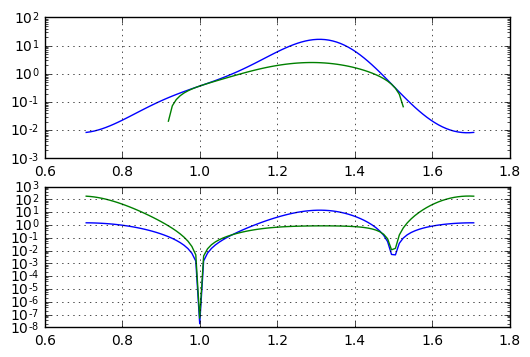

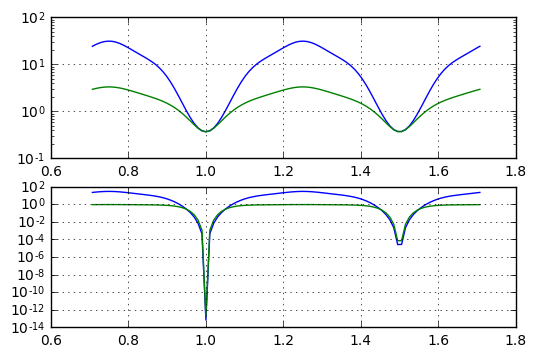

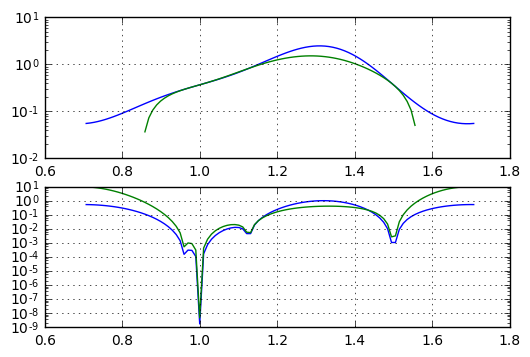

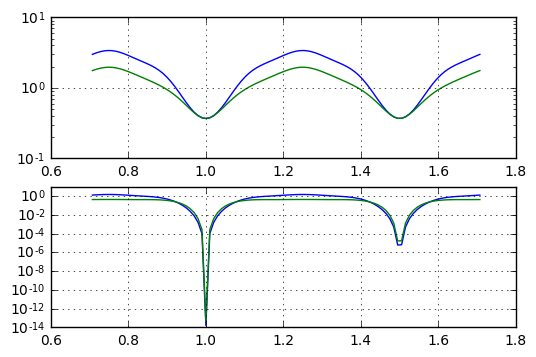

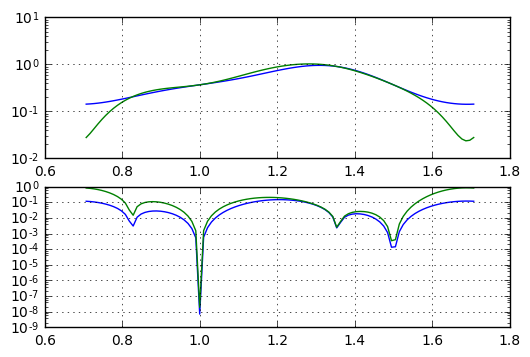

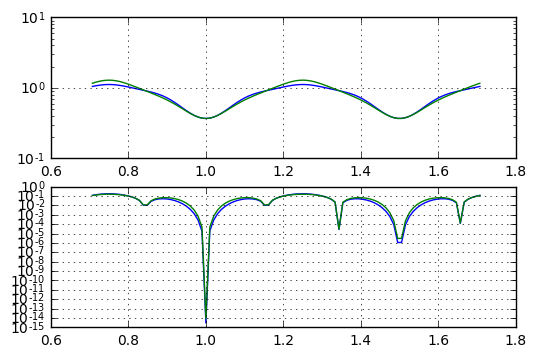

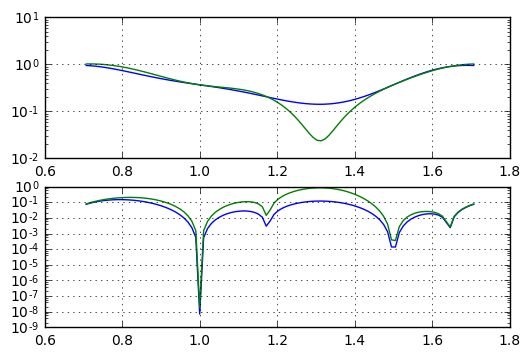

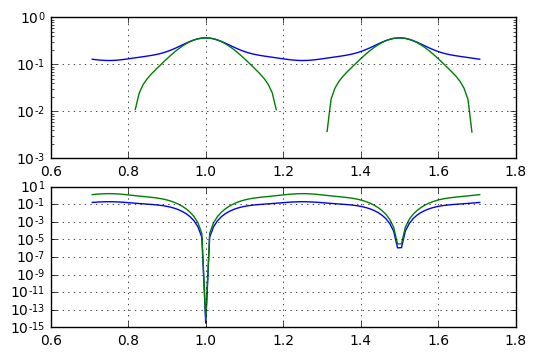

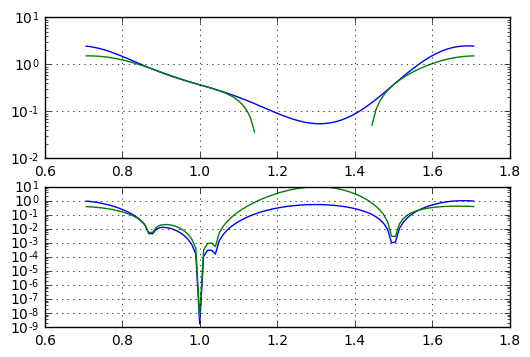

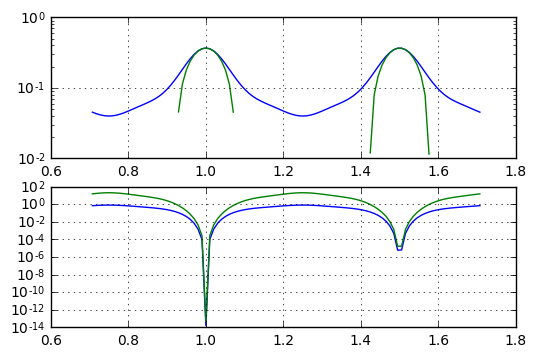

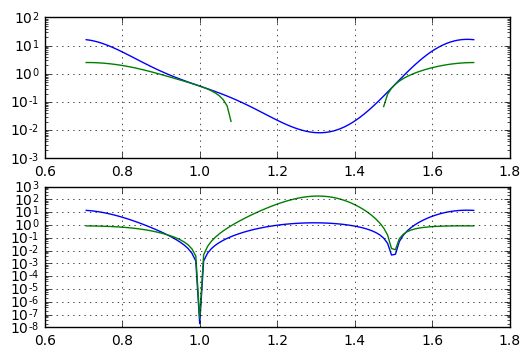

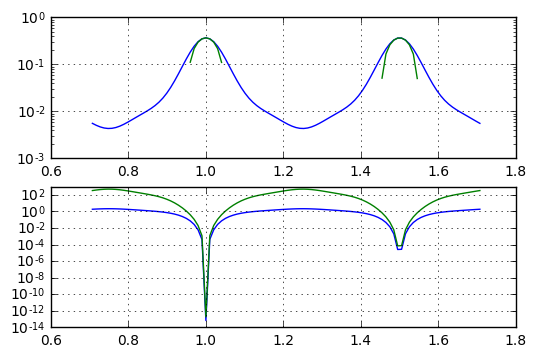

In [14]:
#p = 4
#Lambda = MultiindexSet.createFullTensorSet(M, p) if full_tensor else MultiindexSet.createCompleteOrderSet(M, p, True)
print "Lambda len", len(Lambda)

Xp = np.linspace(X1[0],X1[-1],100)

for yi in [-4,-2,-1,1,2,4]:
    for i in [1,2]:
        fig = plt.figure()

        ax1 = fig.add_subplot(211)
        if i == 1:
            l = [lhs2([xi,X[0][1]], [yi] * M, a, a_mean, with_exp=True) for xi in Xp]
            r = [rhs2([xi,X[0][1]], [yi] * M, a, Lambda, lambda n, x: h.eval(n, x), a_mean) for xi in Xp]
        else:
            l = [lhs2([xi,xi], [yi] * M, a, a_mean, with_exp=True) for xi in Xp]
            r = [rhs2([xi,xi], [yi] * M, a, Lambda, lambda n, x: h.eval(n, x), a_mean) for xi in Xp]
        e = [np.abs(li-ri) for li, ri in zip(l,r)]
        er = [np.abs(li-ri) / li for li, ri in zip(l,r)]
        ax1.semilogy(Xp, l)
        ax1.semilogy(Xp, r)
        #ax1.semilogy(Xp, [lhs2([xi,X[0][1]], [-1] * M, a, a_mean, with_exp=not True) for xi in Xp])
        ax1.grid(True)

        ax1 = fig.add_subplot(212)
        if np.sum(e) < 1e-15:
            e = map(lambda x: x + 1e-15, e)
            er = map(lambda x: x + 1e-15, er)
        ax1.semilogy(Xp, e)
        ax1.semilogy(Xp, er)
        ax1.grid(True)
    
plt.show()

## introduce weighting transformation $\tau_\rho:\mathbb{R}^\infty\to\mathbb{R}^\infty$, $(y_m)_m\mapsto (e^{-\rho\alpha_m}y_m)_m$ and check orthogonality of transformed Hermite polynomials wrt. $\gamma_\rho$ with density $\frac{1}{(2\pi)^{1/2} \rho \prod_{m\geq 1}\sigma_m}e^{-\frac{1}{2\rho}\sum_{m\geq 1}x_m^2\sigma_m^{-2}}$

In [85]:
def eval_alpha(a, range=[-1,1], N=1000):
    X = np.linspace(range[0], range[1], N)
    XX, YY = np.meshgrid(X, X)
    alpha = [np.max([am(x) for x in zip(XX,YY)]) for am in a]
    return alpha

def tau_rho(y, alpha, rho, inverse=False):
    if not hasattr(y, '__iter__'):
        y = [y]  # ensure this works for scalars
    assert len(y) <= len(alpha)
    expsign = 1 if inverse else -1
    val = [np.exp(expsign*rho*alpham)*ym for alpham, ym in zip(alpha,y)]
    return val

determine weights $(\alpha_m)_m:=(||a_m||_{L^\infty(D)})_m$ of coefficient field

In [57]:
alpha = eval_alpha(a)
print alpha

[0.99999752765872296, 0.24999938191468074, 0.11110863878613393]


standard univariate Hermite $\mathrm{He}_n(x)$ polynomials are orthogonal wrt. standard Gauss measure $\gamma$ with density $\frac{1}{\sqrt{2\pi}}e^{-\frac{x^2}{2}}$ and have to be normalised with $n!^{-1/2}$

In [69]:
print "He normality"
print [quad(lambda x: He(n, x)**2*np.exp(-x**2/2), -np.inf, np.inf)[0] / (np.sqrt(2*np.pi)*fac(n)) for n in range(1,10)]
print "h normality"
print [quad(lambda x: h.eval(n, x)**2*np.exp(-x**2/2), -np.inf, np.inf)[0] / (np.sqrt(2*np.pi)*fac(n)) for n in range(1,10)]
print "sample orthogonality"
p = lambda x: np.exp(-x**2/2) / np.sqrt(2*np.pi)
facmn = lambda m, n: np.sqrt(fac(m)*fac(n))
print np.array([[quad(lambda x: He(m, x)*He(n, x)*p(x), -np.inf, np.inf)[0] / facmn(m,n)
       for n in range(1,10)] for m in range(1,10)])

He normality
[1.0000000000000013, 1.0000000000000024, 1.0, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000007, 1.0000000000000004, 1.0]
h normality
[1.0000000000000013, 1.0000000000000024, 1.0, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000004, 1.0000000000000002, 0.99999999999999989]
sample orthogonality
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0. -0.  0. -0.  0.]
 [ 0.  0.  1.  0. -0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0. -0.  0.]
 [ 0.  0. -0.  0.  1.  0.  0.  0.  0.]
 [ 0. -0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0. -0.  0. -0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.]]


weigthed univariate Hermite polynomials $\mathrm{He}_n(\tau_\rho(x))$ are orthogonal wrt. weighted measure $\gamma_\rho$ with density $\frac{1}{\sqrt{2\pi}\rho\sigma}e^{-\frac{x^2}{2\rho^2\sigma^2}}$.

note that
$$
\gamma_\rho(\mathrm{d}y) = \left(\prod_{m\geq 1}\frac{1}{\sigma_m}\right)\exp\left(\frac12 \sum_{m\geq 1}(\sigma_m^{-2}-1)y_m^2\right) \gamma(\mathrm{d}y)
$$

In [101]:
rho = 1
alpha = [eval_alpha(a)[0]]         # we only consider univariate polynomials
alpha = [1]
He_r = lambda n, x: He(n, tau_rho(x, alpha, rho)[0])
p_rho = lambda x: np.exp(-x**2/(2*(rho*alpha[0])**2)) / (np.sqrt(2*np.pi)*rho*alpha[0])
z_rho = lambda x: np.exp(-x**2/2 * (1/alpha[0]**2 - 1)) / alpha[0]
facn = lambda x: fac(n)
print [quad(lambda x: He_r(n, x)**2 * p(x), -np.inf, np.inf)[0] / facn(n) for n in range(1,10)]
print [quad(lambda x: He_r(n, x)**2 * z_rho(x) * p(x), -np.inf, np.inf)[0] / facn(n) for n in range(1,10)]
print [quad(lambda x: He_r(n, x)**2 * p_rho(x), -np.inf, np.inf)[0] / facn(n) for n in range(1,10)]

[0.1353352832366128, 0.39213817509648935, 0.15425288863038247, 0.25103118698301113, 0.15115301573255643, 0.19007364419298978, 0.14226425374075527, 0.15739808985628218, 0.13246509077245186]
[0.1353352832366128, 0.39213817509648935, 0.15425288863038247, 0.25103118698301113, 0.15115301573255643, 0.19007364419298978, 0.14226425374075527, 0.15739808985628218, 0.13246509077245186]
[0.1353352832366128, 0.39213817509648935, 0.15425288863038247, 0.25103118698301113, 0.15115301573255643, 0.19007364419298978, 0.14226425374075527, 0.15739808985628218, 0.13246509077245186]


## test basis transform from $H(y)$ to $H_\rho(y)=H(y\circ\tau_\rho)$ and back

In [ ]:
w1, s1 = lambda x: np.exp(-x**2/2), np.sqrt(2*np.pi)
w2, s2 = lambda x: np.exp(-x**2/(2*rho*alpha[0])), np.sqrt(2*np.pi*rho*alpha[0])

print np.array([[quad(lambda x: He_r(n, x)*He(m, x)*w1(x), -np.inf, np.inf)[0]/(s1*np.sqrt(fac(n)*fac(m)))
                   for n in range(1,10)] for m in range(1,10)])
print np.array([[quad(lambda x: He_r(n, x)*He(m, x)*w2(x), -np.inf, np.inf)[0]/(s2*np.sqrt(fac(n)*fac(m)))
                   for n in range(1,10)] for m in range(1,10)])

In [ ]:
print [quad(lambda x: He(n, x)*He(1, x)*np.exp(-x**2/(2*rho*alpha[0])), -np.inf, np.inf)[0]/(np.sqrt(2*np.pi)*np.sqrt(fac(1)*fac(n)))
       for n in range(1,15)]